## BalanceNet prototype

In [5]:
%run Setup.ipynb
%run ExtraFunctions.ipynb

[i] Loaded Parameters:
 40000 35 0.2 200 
 dataset/glove/glove.twitter.27B.200d.txt
[i] Importing Modules...
[+] Finished Importing Modules
[i] Reading from csv file...Loading from data merged...
Done!
[i] Found 34359 unique tokens.
[+] Shape of data tensor: (239953, 30)
[+] Shape of label tensor: (239953, 10)
[i] Number of entries in each category:
[+] Training:
 [    0. 18484. 78791.  9602.  4611.  3475. 20280. 26203. 24899.  5618.]
[+] Validation:
 [    0.  4450. 19784.  2427.  1129.   866.  5198.  6391.  6245.  1500.]
[i] Loading GloVe from: dataset/glove/glove.twitter.27B.200d.txt ...Done.
[+] Proceeding with Embedding Matrix...[i] Completed!
[i] Finished running setup.


In [6]:
# second embedding matrix for non-static channel
embedding_matrix_ns = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix_ns[i] = embedding_vector
print("Completed!")

Completed!


In [7]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

# static channel
embedding_layer_frozen = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)
embedded_sequences_frozen = embedding_layer_frozen(sequence_input)

# non-static channel
embedding_layer_train = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix_ns],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)
embedded_sequences_train = embedding_layer_train(sequence_input)

First Half: LSTM > CNN

In [8]:
l_lstm1f = Bidirectional(LSTM(6,return_sequences=True,dropout=0.3, recurrent_dropout=0.0))(embedded_sequences_frozen)
l_lstm1t = Bidirectional(LSTM(6,return_sequences=True,dropout=0.3, recurrent_dropout=0.0))(embedded_sequences_train)
l_lstm1 = Concatenate(axis=1)([l_lstm1f, l_lstm1t])

In [9]:
l_conv_2 = Conv1D(filters=24,kernel_size=2,activation='relu')(l_lstm1)
l_conv_2 = Dropout(0.3)(l_conv_2)
l_conv_3 = Conv1D(filters=24,kernel_size=3,activation='relu')(l_lstm1)
l_conv_3 = Dropout(0.3)(l_conv_3)

l_conv_5 = Conv1D(filters=24,kernel_size=5,activation='relu',)(l_lstm1)
l_conv_5 = Dropout(0.3)(l_conv_5)
l_conv_6 = Conv1D(filters=24,kernel_size=6,activation='relu',kernel_regularizer=regularizers.l2(0.0001))(l_lstm1)
l_conv_6 = Dropout(0.3)(l_conv_6)

l_conv_8 = Conv1D(filters=24,kernel_size=8,activation='relu',kernel_regularizer=regularizers.l2(0.0001))(l_lstm1)
l_conv_8 = Dropout(0.3)(l_conv_8)

conv_1 = [l_conv_6,l_conv_5, l_conv_8,l_conv_2,l_conv_3]

l_lstm_c = Concatenate(axis=1)(conv_1)

Second Half: CNN > LSTM

In [10]:
l_conv_4f = Conv1D(filters=12,kernel_size=4,activation='relu',kernel_regularizer=regularizers.l2(0.0001))(embedded_sequences_frozen)
l_conv_4f = Dropout(0.3)(l_conv_4f)
l_conv_4t = Conv1D(filters=12,kernel_size=4,activation='relu',kernel_regularizer=regularizers.l2(0.0001))(embedded_sequences_train)
l_conv_4t = Dropout(0.3)(l_conv_4t)

l_conv_3f = Conv1D(filters=12,kernel_size=3,activation='relu',)(embedded_sequences_frozen)
l_conv_3f = Dropout(0.3)(l_conv_3f)
l_conv_3t = Conv1D(filters=12,kernel_size=3,activation='relu',)(embedded_sequences_train)
l_conv_3t = Dropout(0.3)(l_conv_3t)

l_conv_2f = Conv1D(filters=12,kernel_size=2,activation='relu')(embedded_sequences_frozen)
l_conv_2f = Dropout(0.3)(l_conv_2f)
l_conv_2t = Conv1D(filters=12,kernel_size=2,activation='relu')(embedded_sequences_train)
l_conv_2t = Dropout(0.3)(l_conv_2t)

conv_2 = [l_conv_4f, l_conv_4t,l_conv_3f, l_conv_3t, l_conv_2f, l_conv_2t]

l_merge_2 = Concatenate(axis=1)(conv_2)
l_c_lstm = Bidirectional(LSTM(12,return_sequences=True,dropout=0.3, recurrent_dropout=0.0))(l_merge_2)

Combine both halfs of the model

In [11]:
l_merge = Concatenate(axis=1)([l_lstm_c, l_c_lstm])
l_pool = MaxPooling1D(4)(l_merge)
l_drop = Dropout(0.5)(l_pool)
l_flat = Flatten()(l_drop)
l_dense = Dense(26, activation='relu')(l_flat)
preds = Dense(10, activation='softmax')(l_dense)

In [12]:
model = Model(sequence_input, preds)
adadelta = optimizers.Adadelta(lr=0.9, rho=0.95, epsilon=None, decay=0.002)
lr_metric = get_lr_metric(adadelta)
model.compile(loss='categorical_crossentropy',
              optimizer=adadelta,
              metrics=['acc'])

In [13]:
!rm -r logs

In [11]:
tensorboard = callbacks.TensorBoard(log_dir='./logs', histogram_freq=0, batch_size=16, write_grads=True , write_graph=True)
model_checkpoints = callbacks.ModelCheckpoint("checkpoint-{val_loss:.3f}.h5", monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=0)
lr_schedule = callbacks.LearningRateScheduler(initial_boost)

In [12]:
model.summary()
model.save('BalanceNet.h5')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 30)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 30, 200)      6872000     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 30, 200)      6872000     input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 30, 12)       9936        embedding_1[0][0]                
__________________________________________________________________________________________________
bidirectio

In [13]:
#model = keras.models.load_model("checkpoint-0.902.h5")
#model = keras.models.load_model("checkpoint-0.91.h5")

Time to train!!

In [14]:
print("Training Progress:")
model_log = model.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=50, batch_size=256,
          callbacks=[tensorboard, model_checkpoints])



Training Progress:
Train on 191963 samples, validate on 47990 samples
Epoch 1/50
191963/191963 [==============================] - 931s 5ms/step - loss: 1.5496 - acc: 0.4772 - val_loss: 1.3940 - val_acc: 0.5282
Epoch 2/50
191963/191963 [==============================] - 902s 5ms/step - loss: 1.3706 - acc: 0.5349 - val_loss: 1.3070 - val_acc: 0.5577
Epoch 3/50
191963/191963 [==============================] - 882s 5ms/step - loss: 1.3208 - acc: 0.5514 - val_loss: 1.2713 - val_acc: 0.5713
Epoch 4/50
191963/191963 [==============================] - 855s 4ms/step - loss: 1.2916 - acc: 0.5600 - val_loss: 1.2508 - val_acc: 0.5766
Epoch 5/50
191963/191963 [==============================] - 912s 5ms/step - loss: 1.2736 - acc: 0.5662 - val_loss: 1.2376 - val_acc: 0.5832
Epoch 6/50
191963/191963 [==============================] - 902s 5ms/step - loss: 1.2579 - acc: 0.5714 - val_loss: 1.2241 - val_acc: 0.5888
Epoch 7/50
191963/191963 [==============================] - 904s 5ms/step - loss: 1.2455 -

In [1]:
import pandas
pandas.DataFrame(model_log.history).to_csv("history-balance.csv")

NameError: name 'model_log' is not defined

## Model Testing and Inference

In [14]:
from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
%config InlineBackend.figure_format = 'retina'
import itertools, pickle

with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

classes = ["happy", "sad", "surprise","worry", "disgust", "annoy", "joke","intrigue", "awesome"]

In [15]:
! ls

architectures	      checkpoint-1.173.h5  checkpoint-1.307.h5
BalanceNet-1.0.ipynb  checkpoint-1.175.h5  checkpoint-1.328.h5
BalanceNet.h5	      checkpoint-1.177.h5  checkpoint-1.394.h5
checkpoint-1.136.h5   checkpoint-1.178.h5  checkpoint-1.464.h5
checkpoint-1.137.h5   checkpoint-1.179.h5  checkpoint-1.533.h5
checkpoint-1.138.h5   checkpoint-1.181.h5  ClassMerge.ipynb
checkpoint-1.140.h5   checkpoint-1.184.h5  _config.yml
checkpoint-1.141.h5   checkpoint-1.185.h5  data.big
checkpoint-1.142.h5   checkpoint-1.186.h5  data.csv
checkpoint-1.144.h5   checkpoint-1.189.h5  data_merged.csv
checkpoint-1.145.h5   checkpoint-1.190.h5  data_org.csv
checkpoint-1.146.h5   checkpoint-1.192.h5  dataset
checkpoint-1.147.h5   checkpoint-1.193.h5  experiments
checkpoint-1.148.h5   checkpoint-1.197.h5  ExtraFunctions.ipynb
checkpoint-1.149.h5   checkpoint-1.199.h5  Filter Tweets.ipynb
checkpoint-1.151.h5   checkpoint-1.200.h5  history-balance.csv
checkpoint-1.153.h5   checkpoint-1.201.h5  images
checkpoin

In [16]:
model_test = load_model('checkpoint-1.136.h5')
#model_test = load_model('best_weights.h5')
Y_test = np.argmax(y_val, axis=1) # Convert one-hot to index
y_pred = model_test.predict(x_val)
y_pred_class = np.argmax(y_pred,axis=1)
cnf_matrix = confusion_matrix(Y_test, y_pred_class)

In [17]:
print(set(y_pred_class))
print(classes)
print(classification_report(Y_test, y_pred_class, target_names=classes))

{1, 2, 3, 4, 5, 6, 7, 8, 9}
['happy', 'sad', 'surprise', 'worry', 'disgust', 'annoy', 'joke', 'intrigue', 'awesome']
              precision    recall  f1-score   support

       happy       0.53      0.47      0.50      4450
         sad       0.63      0.88      0.74     19784
    surprise       0.77      0.46      0.58      2427
       worry       1.00      0.54      0.70      1129
     disgust       0.70      0.04      0.07       866
       annoy       0.48      0.34      0.40      5198
        joke       0.69      0.36      0.47      6391
    intrigue       0.58      0.64      0.61      6245
     awesome       0.73      0.31      0.43      1500

   micro avg       0.62      0.62      0.62     47990
   macro avg       0.68      0.45      0.50     47990
weighted avg       0.63      0.62      0.60     47990



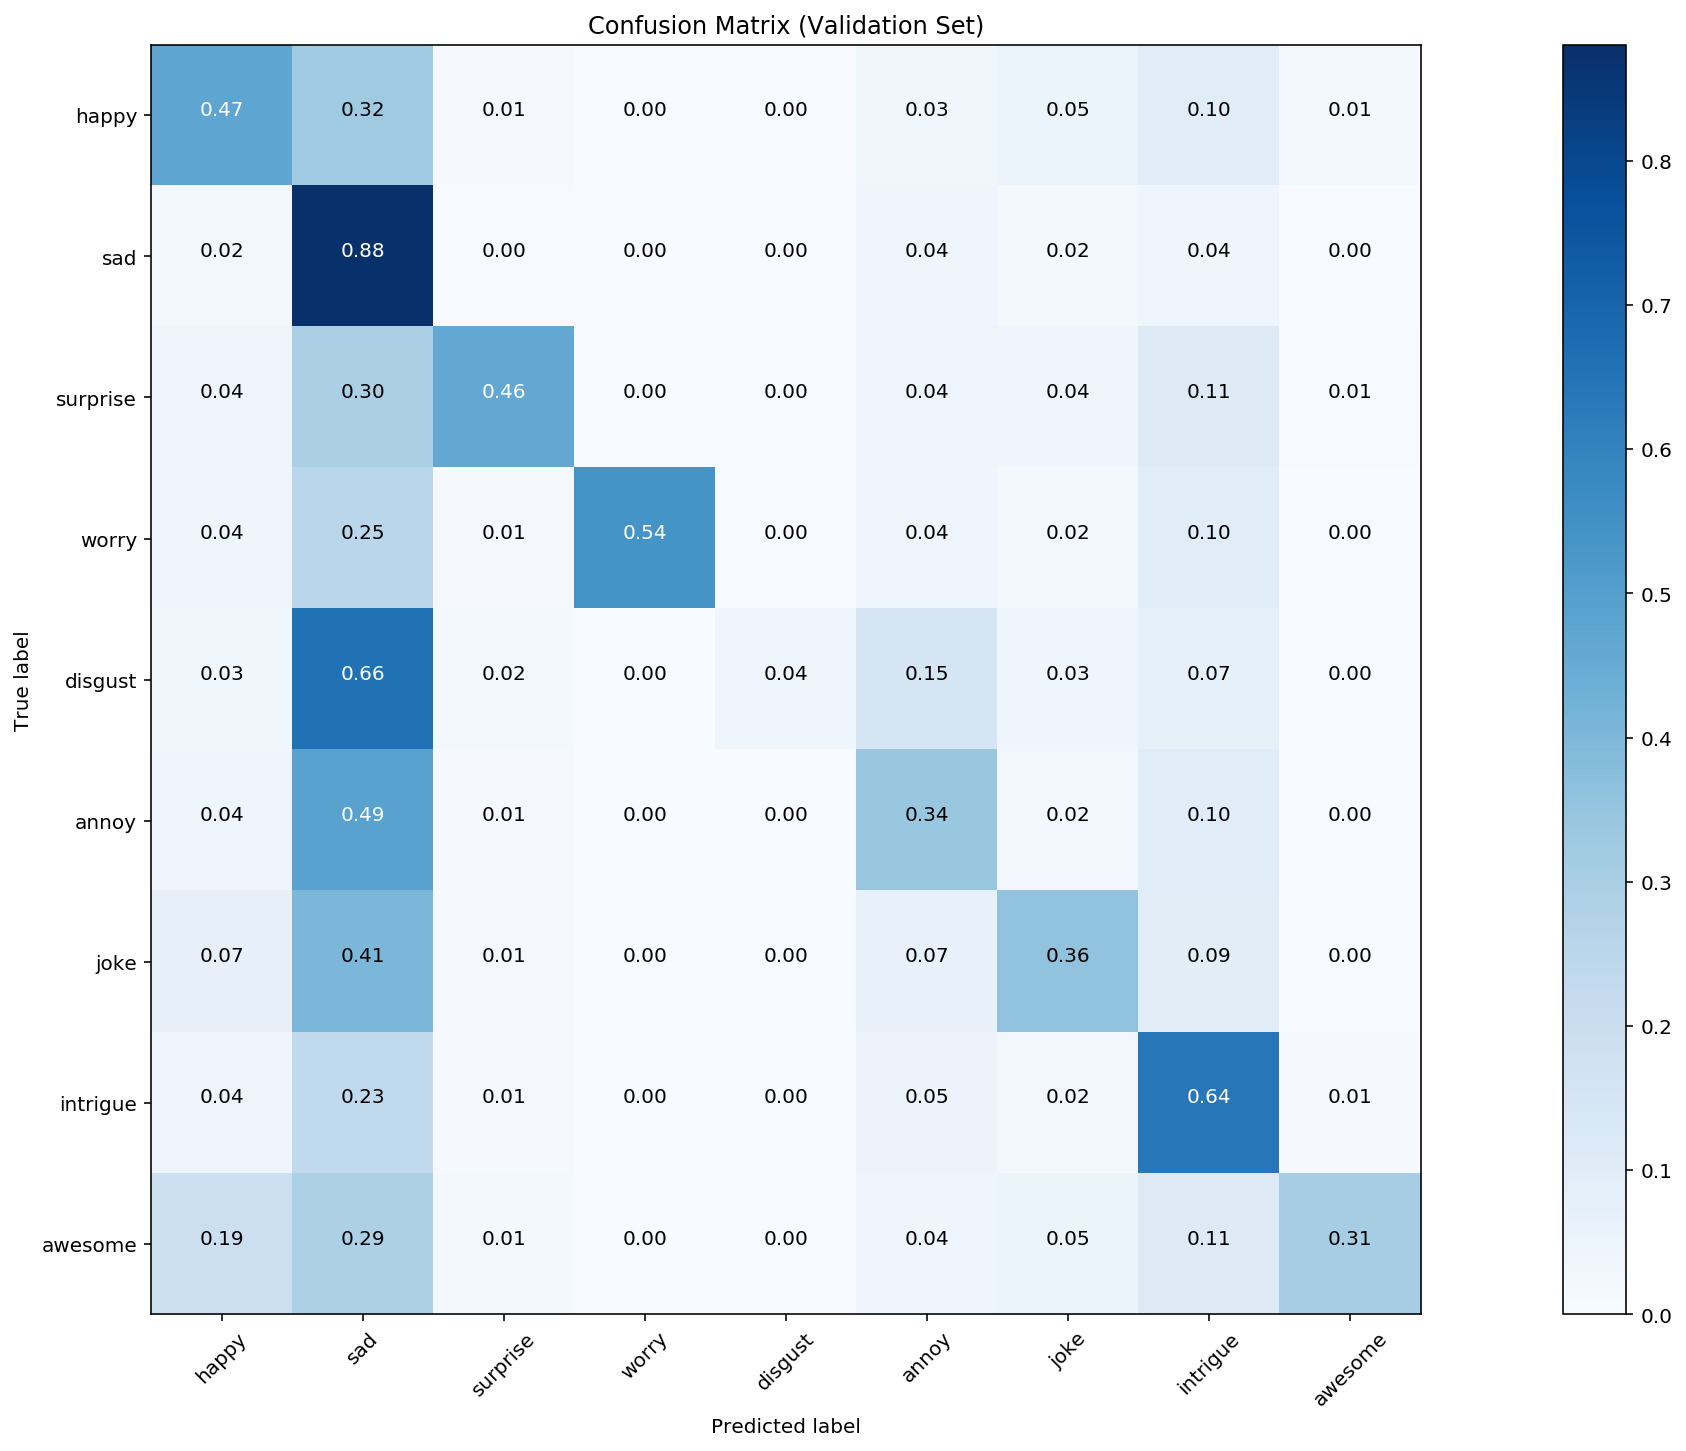

In [18]:
def plot_confusion_matrix(cm, labels,
                          normalize=True,
                          title='Confusion Matrix (Validation Set)',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        #print('Confusion matrix, without normalization')
        pass

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plt.figure(figsize=(20,10))
plot_confusion_matrix(cnf_matrix, labels=classes)

# precision = true_pos / (true_pos + false_pos)
# recall = true_pos / (true_pos + false_neg)

In [23]:
#text = ["I salute you for the bravery and sacrifice! A true hero indeed.",
#        "I am sorry but I trust HRW I damned sight more than the PAP and it's cronies! Off course the PAP will say that they (HRW) made things up...despite of the fact that SG is a dictator state!?",
#        "PAP are taking the piss again!",
#        "Thought he sold his kidney to buy it; Instead, he bought a kidney then bought the car Filthy rich This is why we need communism",
#        "Somebody needs to water Tharman's head, hair needs to be grown there",
#        "what a nuisance fk. a proper clean and flat footpath,,now obstructed by sharedbikes..! which idiotic MP allowed this to happen?",
#        "What baby bonus scheme ??? To grow up a kid in Singapore you think is easy now bo ??? Both parent need to work to grow up a kid until 21 , you think tats easy bo ??? Think la"
#       ]
text = ["I think trump is a liar.",]

In [24]:
from time import time
sequences_test = tokenizer.texts_to_sequences(text)
data_int_t = pad_sequences(sequences_test, padding='pre', maxlen=(MAX_SEQUENCE_LENGTH-5))
data_test = pad_sequences(data_int_t, padding='post', maxlen=(MAX_SEQUENCE_LENGTH))
y_prob = model.predict(data_test)
for n, prediction in enumerate(y_prob):
    st = time()
    pred = y_prob.argmax(axis=-1)[n]
    ed = time()
    
    print(text[n],"\nPrediction:",classes[pred], " | ", pred,", time: ", ed-st,"\n")

I think trump is a liar. 
Prediction: awesome  |  8 , time:  1.9311904907226562e-05 



In [36]:
np.array(sequences_test[0])

array([   1, 6097,    5,   12,    3,    6, 4841,    4,  515, 1476, 1238])